# RAG Implementation for Customer Support

This notebook implements an LLM using RAG on a customer support dataset. This system is designed to provide answers for simple, low priority questions from a user.

## Imports and Loading Data

In [1]:
!pip install kagglehub[pandas-datasets] --quiet
!pip install -U langchain-community --quiet
!pip install tiktoken --quiet #Needed for chromadb
!pip install chromadb --quiet
!pip install rouge_score --quiet

In [2]:
# Install dependencies as needed:
import kagglehub
from kagglehub import KaggleDatasetAdapter

import pandas as pd

from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import DataFrameLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
file_path = "dataset-tickets-multi-lang-4-20k.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "tobiasbueck/multilingual-customer-support-tickets",
  file_path,
)

<ipython-input-3-3398c303bdef>:4: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


In [4]:
# Checking data types of the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   subject   18539 non-null  object
 1   body      19998 non-null  object
 2   answer    19996 non-null  object
 3   type      20000 non-null  object
 4   queue     20000 non-null  object
 5   priority  20000 non-null  object
 6   language  20000 non-null  object
 7   tag_1     20000 non-null  object
 8   tag_2     19954 non-null  object
 9   tag_3     19905 non-null  object
 10  tag_4     18461 non-null  object
 11  tag_5     13091 non-null  object
 12  tag_6     7351 non-null   object
 13  tag_7     3928 non-null   object
 14  tag_8     1907 non-null   object
dtypes: object(15)
memory usage: 2.3+ MB


In [5]:
df = df[df['language'] == 'en']

# Check for non-string items in body

non_string_body = df[~df['body'].apply(lambda x: isinstance(x, str))].index
non_string_answers = df[~df['answer'].apply(lambda x: isinstance(x, str))].index

non_string_ids = non_string_body.union(non_string_answers)

print("Indices with non-string values body or answer:", non_string_ids.tolist())

# Drop those rows
df = df.drop(index=non_string_ids)

df['q_and_a'] = 'Question: ' + df['body'] + ' Answer: ' + df['answer']

df.head()

Indices with non-string values body or answer: [2281, 8891, 14050, 17687]


,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,q_and_a
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,NaN,NaN,NaN,NaN,Question: Seeking information on digital strat...
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Product,Guidance,Documentation,Performance,Feature,NaN,NaN,Question: I am contacting you to request infor...
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,Customer,Compliance,Breach,Documentation,Guidance,NaN,NaN,"Question: Dear Customer Support, I am reaching..."
5,Concerns About Securing Medical Data on 2-in-1...,Inquiring about best practices for securing me...,Thank you for your concern regarding securing ...,Request,Technical Support,medium,en,Security,Product,Feature,IT,Tech Support,NaN,NaN,NaN,Question: Inquiring about best practices for s...
7,Problem with Integration,"The integration stopped working unexpectedly, ...",I will look into the problem and call you at <...,Problem,IT Support,high,en,Technical,Integration,Bug,Resolution,Outage,Documentation,NaN,NaN,Question: The integration stopped working unex...


In [6]:
df_train, df_holdout = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_holdout, test_size=0.5, random_state=42)

print(f"Train set size: {df_train.shape}")
print(f"Validation set size: {df_val.shape}")
print(f"Test set size: {df_test.shape}")

Train set size: (9535, 16)
Validation set size: (1192, 16)
Test set size: (1192, 16)


## Ingest Documents and Setup Vector Database

ChromaDB is used as the vector database that langchain will pull from when RAG is implemented

In [7]:
persist_directory = './chroma_db'
!rm -rf ./chroma_db  # remove old database files if any

In [8]:
loader = DataFrameLoader(
    df_train,
    page_content_column="q_and_a")
documents = loader.load()

In [9]:
from google.colab import userdata
openai_api_key = userdata.get('openai_api_key')

In [10]:
embedding = OpenAIEmbeddings(openai_api_key=openai_api_key)

<ipython-input-10-9f298750086e>:1: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings(openai_api_key=openai_api_key)


In [11]:
vectordb = Chroma.from_documents(
    documents=documents,
    embedding=embedding,
    persist_directory=persist_directory
)

## LLM Integration and Validation

In [12]:
llm_name = "gpt-3.5-turbo"

llm = ChatOpenAI(model_name=llm_name, temperature=0,
                 openai_api_key=openai_api_key)

<ipython-input-12-77231ad7f76d>:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name=llm_name, temperature=0,


A subset of the validation and test dataset are used for evaluation. This is done primarly to reduce the number of calls to the OpenAI API and minimize cost for evaluation.

In [13]:
# Retrieve a random subset from the validation dataset

val_subset = df_val.sample(10).reset_index()

Basic parameters were selected for both temperature and k number of examples to use in RAG. We tried between 0 and 0.7 temperature as 0 may make for a more predictable technical support chatbot and 0.7 is a common industry value.

For k values we kept it low between 1 and 5 to make sure all response fit in the context window.

In [14]:
temps = [0, 0.3, 0.7]
k_vals = [1, 3, 5]

Rouge score is calculated to judge the similarity between the models output and the true answer in the customer support database.

In [15]:
from rouge_score import rouge_scorer
import statistics

def get_rogue(qa_chain, dataset):

  score_1 = []
  score_2 = []
  score_L = []

  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

  for index, row in dataset.iterrows():
    question = row['body']
    answer = row['answer']

    response = qa_chain({"query": question})['result']

    scores = scorer.score(answer, response)

    score_1.append(scores['rouge1'][2])
    score_2.append(scores['rouge2'][2])
    score_L.append(scores['rougeL'][2])

  return statistics.mean(score_1), statistics.mean(score_2), statistics.mean(score_L)




In [21]:
rouge1_all = []
rouge2_all = []
rougeL_all = []

for temp in temps:
    for k in k_vals:

        llm = ChatOpenAI(model_name=llm_name, temperature=temp,
                  openai_api_key=openai_api_key)

        qa_chain = RetrievalQA.from_chain_type(
          llm,
          retriever=vectordb.as_retriever(search_kwargs={"k": k}))

        scores = get_rogue(qa_chain, val_subset)
        print(f"""temp: {temp} k: {k} rouge1: {scores[0]:.2f} rouge2: {scores[1]:.2f} rougeL: {scores[2]:.2f}""")
        rouge1_all.append(scores[0])
        rouge2_all.append(scores[1])
        rougeL_all.append(scores[2])


temp: 0 k: 1 rouge1: 0.74 rouge2: 0.58 rougeL: 0.68
temp: 0 k: 3 rouge1: 0.72 rouge2: 0.56 rougeL: 0.65
temp: 0 k: 5 rouge1: 0.70 rouge2: 0.56 rougeL: 0.65
temp: 0.3 k: 1 rouge1: 0.74 rouge2: 0.58 rougeL: 0.68
temp: 0.3 k: 3 rouge1: 0.67 rouge2: 0.50 rougeL: 0.60
temp: 0.3 k: 5 rouge1: 0.70 rouge2: 0.55 rougeL: 0.65
temp: 0.7 k: 1 rouge1: 0.75 rouge2: 0.58 rougeL: 0.68
temp: 0.7 k: 3 rouge1: 0.72 rouge2: 0.55 rougeL: 0.66
temp: 0.7 k: 5 rouge1: 0.66 rouge2: 0.49 rougeL: 0.60


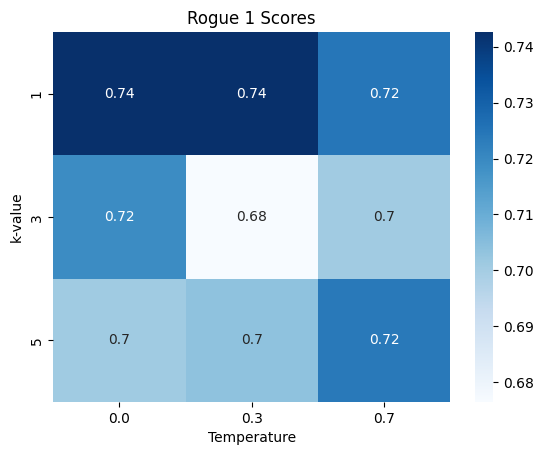

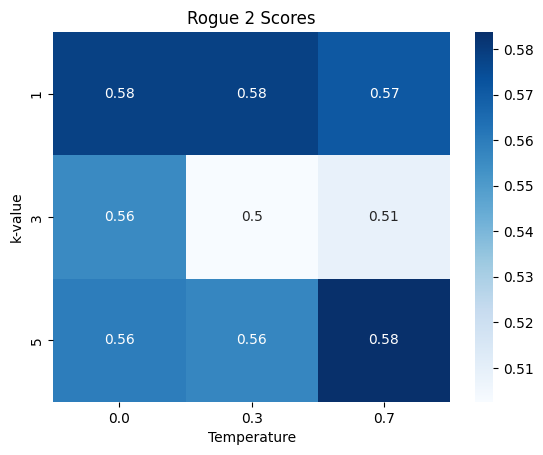

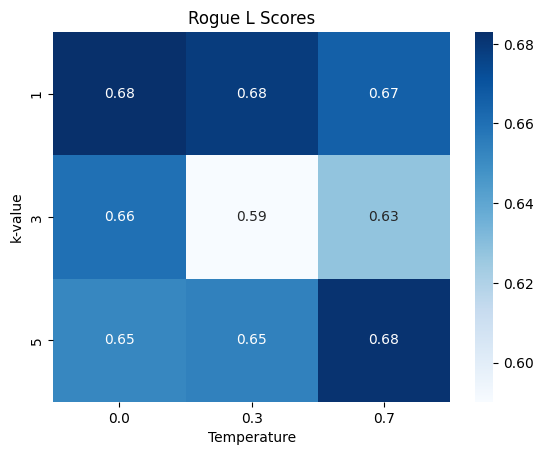

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

x = np.repeat(temps, 3)
y = np.tile(k_vals, 3)

# Create DataFrame (rouge1)
df = pd.DataFrame({'x': x, 'y': y, 'z': rouge1_all})
matrix = df.pivot(index='y', columns='x', values='z')

# Create heatmap
ax = sns.heatmap(matrix, annot=True, cmap='Blues')
ax.set_xlabel('Temperature')
ax.set_ylabel('k-value')
ax.set_title('Rogue 1 Scores')
plt.show()

# Create DataFrame (rouge2)
df = pd.DataFrame({'x': x, 'y': y, 'z': rouge2_all})
matrix = df.pivot(index='y', columns='x', values='z')

# Create heatmap
ax = sns.heatmap(matrix, annot=True, cmap='Blues')
ax.set_xlabel('Temperature')
ax.set_ylabel('k-value')
ax.set_title('Rogue 2 Scores')
print()
plt.show()

# Create DataFrame (rougeL)
df = pd.DataFrame({'x': x, 'y': y, 'z': rougeL_all})
matrix = df.pivot(index='y', columns='x', values='z')

# Create heatmap
ax = sns.heatmap(matrix, annot=True, cmap='Blues')
ax.set_xlabel('Temperature')
ax.set_ylabel('k-value')
ax.set_title('Rogue L Scores')
print()
plt.show()

Rogue scores showed the best response at k=5 and temp=7. While response at these values was slight worse for Rouge1, RougeL showed a better response. RougeL was prioritized as it gave a good indication of the overall structure of responses instead of focusing on only keywords.

### Final Evaluation on Test Set

#### Rouge test set scores

In [27]:
best_temp = 0.7
best_k = 5

test_subset = df_test.sample(10).reset_index()

llm = ChatOpenAI(model_name=llm_name, temperature=best_temp,
                  openai_api_key=openai_api_key)

qa_chain = RetrievalQA.from_chain_type(
          llm,
          retriever=vectordb.as_retriever(search_kwargs={"k": best_k}))

scores = get_rogue(qa_chain, val_subset)
print(f"Test set scores for best set, k={best_k}, temp={best_temp}:")
print(f"""rouge1: {scores[0]:.2f} rouge2: {scores[1]:.2f} rougeL: {scores[2]:.2f}""")

Test set scores for best set, k=5, temp=0.7:
rouge1: 0.70 rouge2: 0.56 rougeL: 0.65


A minor drop in rouge scores was seen as expected when switching from the validation to test dataset.

#### Test dataset example questions and answers

In [28]:
test_subset = df_test.sample(3).reset_index()

import textwrap

def wrap_text(text, width=70):
  wrapped_text = textwrap.fill(text, width=width)
  return wrapped_text

for index, row in test_subset.iterrows():

    question = row['body']
    answer = row['answer']

    response = qa_chain({"query": question})['result']

    print("Question: ", wrap_text(question))
    print()
    print("True Answer: ", wrap_text(answer))
    print()
    print("Model Response: ", wrap_text(response))

    print('\n' + "-" * 50 + '\n')



Question:  Hello Customer Support, I am contacting you to seek information about
the integrations compatible with your project management software. I
am particularly interested in knowing which tools and platforms your
system can connect with, such as Google Drive, Trello, or Slack. I
would also like to know if your software provides APIs or webhooks for
creating custom integrations. Could you give me a detailed list of all
integrations and any associated documentation or resources for setting
them up? It would be helpful to have information on the integration
process, including any specific requirements or limitations.
Furthermore, I am curious about any planned future integrations or
details of your roadmap for upcoming features. I appreciate your time
and look forward to your response. Kind regards, [Your Name]

True Answer:  Hello [Your Name], thank you for your query. Our project management
software supports integrations with Google Drive, Trello, and Slack,
along with other platf

A subjective analysis of random q and a samples within the test dataset shows the model responds overall fairly well. Overall tone matches with expected customer support examples. In addition the content of the responses matches is similar, for example in the first example the model correctly mentions API and webhook availability.